In [77]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,RMSprop
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import homework_utils


In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())
tf.keras.mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
/device:GPU:0


In [24]:
# Load data into pandas DataFrame
df = pd.read_parquet('dataset/unscaled_train_data.parquet')

# Define the feature and target columns
feature_cols = df.columns[:-1]
target_col = df.columns[-1]
O = len(df[target_col].unique())
I = len(feature_cols)

# Define a function to create the Keras model
def create_model(hidden_size:int,lr:float=None,m:float=None):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=len(feature_cols), activation='sigmoid'))
    model.add(Dense(O, activation='softmax'))
    if lr and m:
        optimizer = SGD(learning_rate=lr,momentum=m)
    else:
        optimizer = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_crossentropy','mean_squared_error','accuracy'])
    return model

# Create a 5-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Encode data
x = df[feature_cols]
y = to_categorical(df[target_col])

In [ ]:
from importlib import reload
reload(homework_utils)
scores = []
hidden_layer_matrice = [
    {"hl":I,}, 
    {"hl":int((I+O)/2),}, 
    {"hl":I+O,}, 
]
for conf in hidden_layer_matrice:
    # Create a pipeline with a StandardScaler and a Keras model
    #this is the easy way, but it is limited to only get scores
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KerasClassifier(model=create_model(conf['hl']), epochs=30, batch_size=64,verbose=0))
    ])
    scores.append(homework_utils.wrap_cross_validate(pipe,kf,x,y))

In [ ]:
for score in scores:
    homework_utils.print_scores(score)

Cross Entropy: 0.079 (+/- 0.001)
MSE: 0.009 (+/- 0.000)
Accuracy: 0.976 (+/- 0.000)
Cross Entropy: 0.116 (+/- 0.002)
MSE: 0.014 (+/- 0.000)
Accuracy: 0.966 (+/- 0.001)
Cross Entropy: 0.063 (+/- 0.005)
MSE: 0.008 (+/- 0.001)
Accuracy: 0.981 (+/- 0.002)


In [74]:
historical_results = {}
for conf in hidden_layer_matrice:
    histories = list()
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(df[feature_cols])):
        X = df[feature_cols].values[train_indices]
        Y = to_categorical(df[target_col].values[train_indices])
        Xv = df[feature_cols].values[val_indices]
        Yv = to_categorical(df[target_col].values[val_indices])

        model = create_model(conf['hl'])
        X = StandardScaler().fit_transform(X)
        Xv = StandardScaler().fit_transform(Xv)
        history = model.fit(X,Y,epochs=10,batch_size=64,validation_data=(Xv,Yv),verbose=0)
        histories.append(history)
    historical_results[conf['hl']] = histories

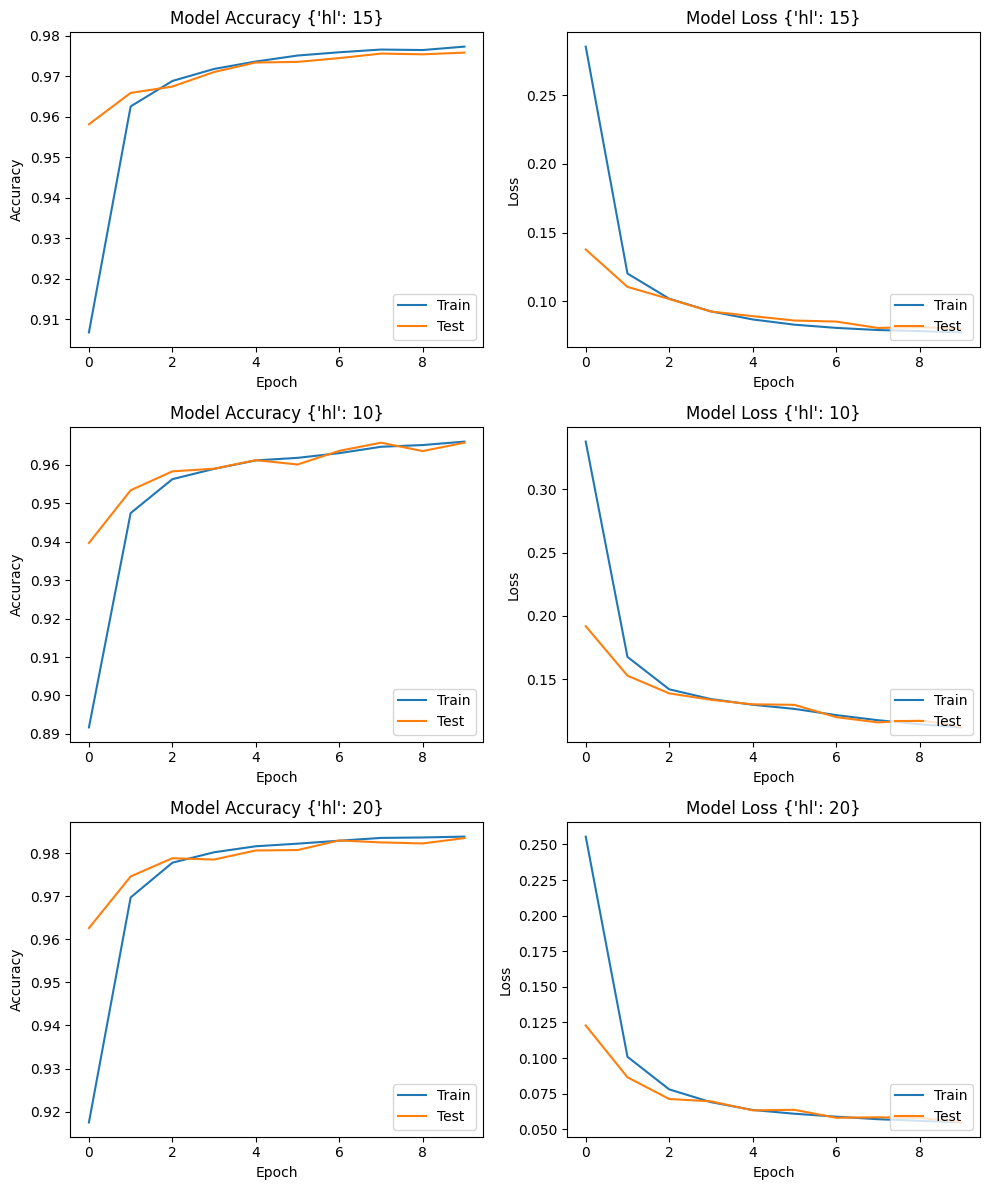

In [75]:
from homework_utils import figure_from_histories

figure_from_histories(
    histories=[v[0] for _,v in historical_results.items()],
    test_matrice=hidden_layer_matrice)

In [83]:
reload(homework_utils)
homework_utils.score_from_history(historical_results[I][0])

{'loss': 0.07733062654733658,
 'categorical_crossentropy': 0.07716149836778641,
 'mean_squared_error': 0.007199326995760202,
 'accuracy': 0.9773593544960022,
 'val_loss': 0.08012441545724869,
 'val_categorical_crossentropy': 0.08003344386816025,
 'val_mean_squared_error': 0.007512992713600397,
 'val_accuracy': 0.9758806824684143}

In [ ]:
test_matrice=[
    {'lr':0.001,'m':0.2},
    {'lr':0.001,'m':0.6},
    {'lr':0.05,'m':0.6},
    {'lr':0.1,'m':0.6},
]
results = []
for cond in test_matrice:
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KerasClassifier(model=create_model(I+O,lr=cond['lr'],m=cond['m']), epochs=10, batch_size=64,verbose=0))
    ])

    score = wrap_cross_validate(pipe)
    results.append(
        {
            'condition':cond,
            'score':score,
        }
    )

In [29]:
for res in results:
    print(res['condition'])
    print_scores(res['score'])
    print('='*30)

{'lr': 0.001, 'm': 0.2}
Cross Entropy: 0.794 (+/- 0.001)
MSE: 0.105 (+/- 0.000)
Accuracy: 0.737 (+/- 0.001)
{'lr': 0.001, 'm': 0.6}
Cross Entropy: 0.654 (+/- 0.001)
MSE: 0.088 (+/- 0.001)
Accuracy: 0.781 (+/- 0.001)
{'lr': 0.05, 'm': 0.6}
Cross Entropy: 0.118 (+/- 0.002)
MSE: 0.014 (+/- 0.000)
Accuracy: 0.966 (+/- 0.001)
{'lr': 0.1, 'm': 0.6}
Cross Entropy: 0.095 (+/- 0.002)
MSE: 0.011 (+/- 0.000)
Accuracy: 0.972 (+/- 0.000)


In [71]:
test_matrice=[
    {'lr':0.001,'m':0.2},
    {'lr':0.001,'m':0.6},
    {'lr':0.05,'m':0.6},
    {'lr':0.1,'m':0.6},
]
histories = []
for cond in test_matrice:
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(df[feature_cols])):
        X = df[feature_cols].values[train_indices]
        Y = to_categorical(df[target_col].values[train_indices])
        Xv = df[feature_cols].values[val_indices]
        Yv = to_categorical(df[target_col].values[val_indices])

        model = create_model(I+O,lr=cond['lr'],m=cond['m'])
        X = StandardScaler().fit_transform(X)
        Xv = StandardScaler().fit_transform(Xv)
        history = model.fit(X,Y,epochs=10,batch_size=64,validation_data=(Xv,Yv),verbose=0)
        histories.append(history)
        #altough generally 5 fold validation means I have to check all of them, I will only check the first
        break

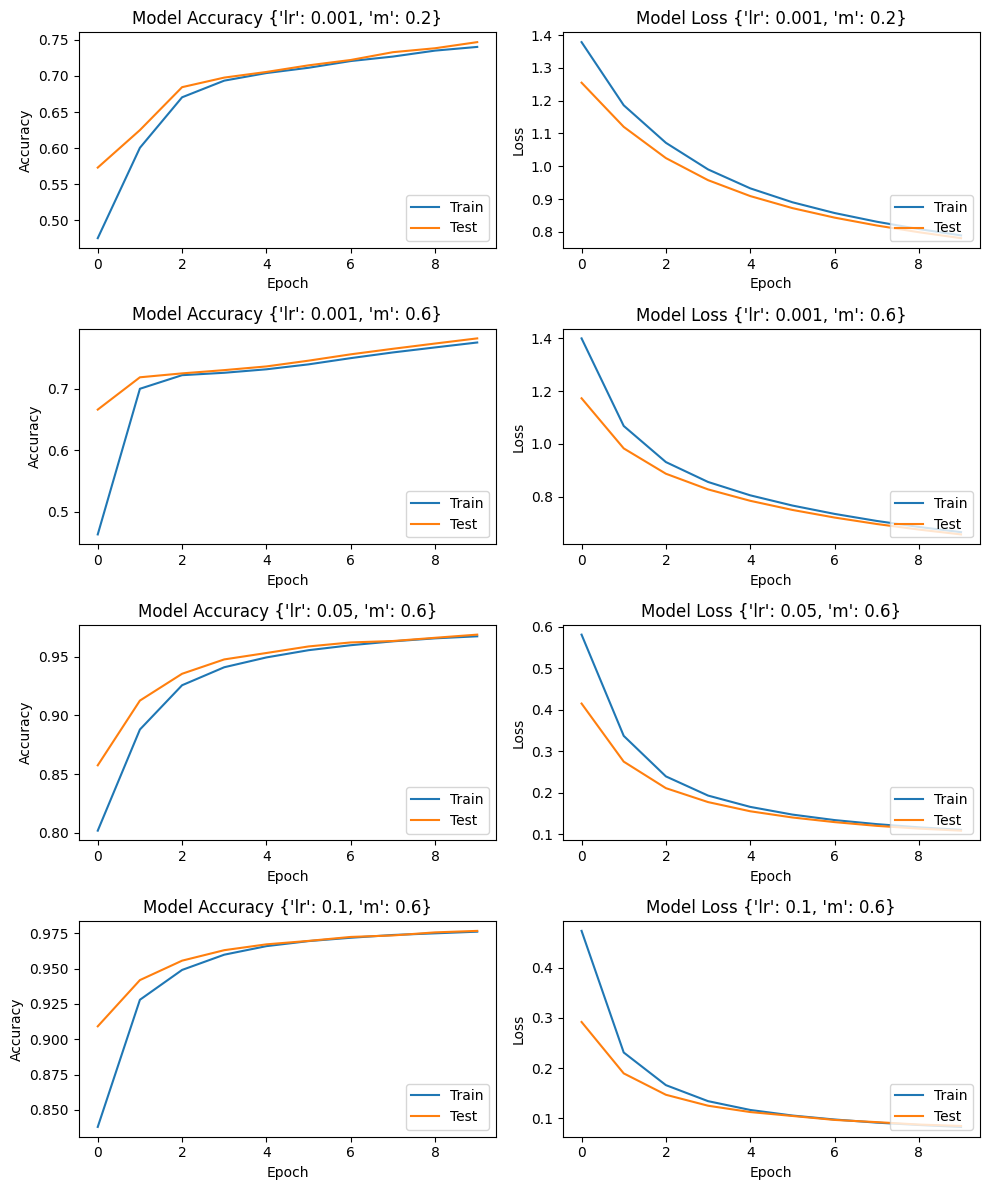

In [72]:
# set up the figure
figure_from_histories(histories,test_matrice)


In [ ]:
from keras import regularizers
def create_normalised_model(coef):
    model = Sequential()
    model.add(Dense(I+O, input_dim=len(feature_cols), activation='sigmoid',bias_regularizer=regularizers.L2(coef)))
    model.add(Dense(O, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_crossentropy','mean_squared_error','accuracy'])
    return model

In [ ]:
test_matrice_reg=[
    {'coef':0.1},
    {'coef':0.5},
    {'coef':0.9},
]

histories = []
for cond in test_matrice_reg:
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(df[feature_cols])):
        X = df[feature_cols].values[train_indices]
        Y = to_categorical(df[target_col].values[train_indices])
        Xv = df[feature_cols].values[val_indices]
        Yv = to_categorical(df[target_col].values[val_indices])

        model = create_normalised_model(cond['coef'])
        X = StandardScaler().fit_transform(X)
        Xv = StandardScaler().fit_transform(Xv)
        history = model.fit(X,Y,epochs=10,batch_size=64,validation_data=(Xv,Yv),verbose=0)
        histories.append(history)


#TODO create score from histories
